# imports

In [ ]:
import SEAM.datasets
# raw dataset/processed dataset
import SEAM.tl.Cut
# load segmentation result, and get anndata, prepare obs/obsm, e.g. spatial...
import SEAM.tl.ID
# run ID and add ID representation to adata
import SEAM.tl.Umap
# run UMAP using SIMSID/mean
import SEAM.tl.Cluster
# run clustering algorithms, updata obs cluster of anndata
import SEAM.tl.Diff
# run differential methods, either SIMS-Diff or single cell methods, update anndata
import SEAM.tl.View
# run SIMS-View, update anndata, user can select color space and DM methods
import SEAM.tl.ME
# input list of points to form polylines, update anndata as boxplot/lineplot associated variables.


import SEAM.pl.IMS
# raw data ploting
import SEAM.pl.Cut
# ploting cut result, dot, real, or overlay of real/134
import SEAM.pl.ID
# ploting umap/PCA/Tsne of ID
import SEAM.pl.Cluster
# ploting spatial single cell map dot/real
import SEAM.pl.Diff
# plot heatmap given a set of genes
import SEAM.pl.View
# plot SIMS-View
import SEAM.pl.ME
# plot polyline overlay with cut/clustering, plot boxplot/lineplot



# settings

In [157]:
import palettable
sc.set_figure_params(dpi=500, color_map='viridis',dpi_save=500,transparent=True)

sc.settings.verbosity = 2
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap

# SEAM.datasets

In [12]:
import numpy as np
import pandas as pd
import anndata as ad
import scipy.io as sio
import pickle

DATA_PATH_IMS_PROCESSED = '/home/yzy/SEAM/data/process/'
DATA_PATH_DUMP = '/home/yzy/SEAM/data/dump/'
def get_train_data(data_mat_filename,mode,norm,batch_num_list=[1]):



    original_data = {}
    cell_related_data = {}
    data_mat = sio.loadmat(data_mat_filename)
    data_mat=data_mat['data_mat']



    num_features = data_mat.shape[1]-3
    batch_dict = {}

    label_dict = {}
    cell_dict = {}
    pos_dict = {}

    for i in range(1):

            cur_data = data_mat[data_mat[:,0]==i+1,3:num_features+3]


            batch_dict[i+1] = cur_data

            cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
            cur_batch_idx = data_mat[data_mat[:,0]==i+1,2]
            label_dict[i+1] = np.ones(shape=cur_batch_idx.shape)


            pos_dict[i+1] = cur_batch_idx
    original_data['batch_dict'] = batch_dict
    original_data['cell_dict'] = cell_dict
    original_data['label_dict'] = label_dict
    original_data['pos_dict'] = pos_dict






    top_n_var = 250
    train_x_all = None
    cell_idx_all = None
    cell_type_all = None
    cell_pos_all = None
    batch_idx_all = None
    num_cells_all = 0


    for batch_num in batch_num_list:
        train_x = batch_dict[batch_num]
        # train_x = eval('batch_dict_{norm_type}[batch_num]'.format(norm_type=norm_type))
        # train_x = batch_dict[batch_num]
        cell_idx = cell_dict[batch_num]
        cell_type = label_dict[batch_num]
        cell_pos = pos_dict[batch_num]
        # batch_FE = FE_dict[batch_num]
        cell_related_ind = (cell_idx!=0)

        num_cells = int(np.max(cell_idx))
        # num_cells = 2
        train_x = train_x[cell_related_ind,:]

        cell_idx = cell_idx[cell_related_ind]
        cell_type = cell_type[cell_related_ind]
        # cell_type = np.ones(shape=cell_idx.shape)
        cell_pos = cell_pos[cell_related_ind]





        var_li = []
        normed_var_li = []
        for i in range(train_x.shape[1]):
            cur_col = train_x[:,i]
        #     cur_col= cur_row/np.sum(cur_col)
        #     cur_entropy = entropy(cur_col)
            cur_var = np.var(cur_col)
            cur_normed_var = cur_var/np.mean(cur_col)
        #     entropy_li.append(cur_entropy)
            var_li.append(cur_var)
            normed_var_li.append(cur_normed_var)
        # entropy_li = np.array(entropy_li)
        var_li = np.array(var_li)
        normed_var_li = np.array(normed_var_li)
        sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
        sort_val = np.flip(np.sort(normed_var_li),axis=0)
        
        if train_x_all is None:
            train_x_all = train_x
        else:
            train_x_all = np.vstack([train_x_all,train_x])
        if cell_idx_all is None:
            cell_idx_all = cell_idx
        else:
            cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
        if cell_type_all is None:
            cell_type_all = cell_type
        else:
            cell_type_all = np.hstack([cell_type_all,cell_type])
        if cell_pos_all is None:
            cell_pos_all = cell_pos
        else:
            cell_pos_all = np.hstack([cell_pos_all,cell_pos])
        if batch_idx_all is None:
            batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
        else:
            batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])


    train_x = train_x_all
    cell_idx = cell_idx_all
    cell_type = cell_type_all
    cell_pos = cell_pos_all
    batch_idx = batch_idx_all
    num_cells = np.max(cell_idx)
    if mode=='none':
        train_x = train_x
    elif mode=='median':
        train_x = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    elif mode=='total':
        train_x = train_x/np.sum(train_x,axis=1,keepdims=True)
        train_x = np.log(train_x+1)

    if norm=='standard':
        train_x = StandardScaler().fit_transform(train_x)
    elif norm=='l1':
        train_x = Normalizer(norm='l1').fit_transform(train_x)
    elif norm=='l2':
        train_x = Normalizer(norm='l2').fit_transform(train_x)
    elif norm=='none':
        train_x = train_x

    cell_related_data['train_x'] = train_x
    cell_related_data['cell_idx'] = cell_idx
    cell_related_data['cell_type'] = cell_type
    cell_related_data['cell_pos'] = cell_pos
    cell_related_data['batch_idx'] =batch_idx
    cell_related_data['num_cells'] = num_cells
    return original_data,cell_related_data



def load_raw_SIMS(data):
    data_mat_filename_temp = DATA_PATH_IMS_PROCESSED+'{0}/cut/rst/datamat.mat'
    matter_list_filename_temp=DATA_PATH_IMS_PROCESSED+'{0}/preprocess/matters_candidate.pkl'

#     data = 'P6_neg1_low0_None_auto'
    test_sample_temp=DATA_PATH_IMS_PROCESSED+'{0}/preprocess/test_samples.mat'



    matter_list_filename = matter_list_filename_temp.format(data)
    data_mat_filename = data_mat_filename_temp.format(data)
    test_sample_filename = test_sample_temp.format(data)
    test_sample_all = sio.loadmat(test_sample_filename)['test_samples']
    mode='none'
    norm='none'
    [original_data,cell_related_data]=get_train_data(data_mat_filename,mode,norm,batch_num_list=[1])
    train_x=cell_related_data['train_x']
    cell_idx=cell_related_data['cell_idx']
    cell_pos=cell_related_data['cell_pos']
    num_cells = np.max(cell_idx)
    matter_list = pickle.load(open(matter_list_filename,'rb'))
    matter_list = np.array(matter_list)

    return train_x,cell_idx,cell_pos,matter_list,num_cells,test_sample_all


def get_mean_representation(train_x,cell_idx,num_cells):
    train_x_tmp = train_x.copy()
    train_x_median = (train_x_tmp+1)/(np.percentile(train_x_tmp,50,axis=1,keepdims=True)+1)
    train_x_total = train_x/np.sum(train_x,axis=1,keepdims=True)
    train_x_median = np.log(train_x_median+1)
    train_x_total = np.log(train_x_total+1)
    # train_x_A = (train_x+1)/(train_x[:,matter_list==134.06]+1)
    sum_profile_list_median = []
    sum_profile_list_total = []

    max_profile_list_median = []
    max_profile_list = []
    mean_profile_list_median = []
    max_profile_list_total = []
    mean_profile_list_total = []
    mean_profile_list=[]
    # mean_profile_list_A=[]
    # max_profile_list_A = []
    for i in range(num_cells):
            mean_profile_list_median.append(np.mean(train_x_median[cell_idx==i+1,:],axis=0))
            max_profile_list_median.append(np.max(train_x_median[cell_idx==i+1,:],axis=0))
            max_profile_list.append(np.max(train_x[cell_idx==i+1,:],axis=0))
    #         mean_profile_list_A.append(np.mean(train_x_A[cell_idx==i+1,:],axis=0))
    #         max_profile_list_A.append(np.max(train_x_A[cell_idx==i+1,:],axis=0))

            sum_profile_list_median.append(np.sum(train_x_median[cell_idx==i+1,:],axis=0))
            mean_profile_list.append(np.mean(train_x[cell_idx==i+1,:],axis=0))
            mean_profile_list_total.append(np.mean(train_x_total[cell_idx==i+1,:],axis=0))
            max_profile_list_total.append(np.max(train_x_total[cell_idx==i+1,:],axis=0))
            sum_profile_list_total.append(np.sum(train_x_total[cell_idx==i+1,:],axis=0))

    mean_profile_list_median = np.array(mean_profile_list_median)
    max_profile_list_median = np.array(max_profile_list_median)
    mean_profile_list_total = np.array(mean_profile_list_total)
    max_profile_list_total = np.array(max_profile_list_total)
    sum_profile_list_median = np.array(sum_profile_list_median)
    sum_profile_list_total = np.array(sum_profile_list_total)
    mean_profile_list = np.array(mean_profile_list)
    max_profile_list = np.array(max_profile_list)
    # mean_profile_list_A = np.array(mean_profile_list_A)
    # max_profile_list_A = np.array(max_profile_list_A)
    return mean_profile_list_median


def load_dataset_raw(data):
    train_x,cell_idx,cell_pos,matter_list,num_cells,test_sample_all = load_raw_SIMS(data)
    mean_profile_list_median = get_mean_representation(train_x,cell_idx,num_cells)
    
    in_X = mean_profile_list_median
    # g = map(str,range(in_X.shape[1]))
    g = map(str,matter_list)
    Genes = []
    None_idx = 0
    Genes = g
    # obs_name must be str
    obs_name = list(map(str,range(in_X.shape[0])))
    obs = pd.DataFrame(index=obs_name)

    # var_name must be str
    var = pd.DataFrame(index=Genes)

    #     var['Genes'] = Genes
    a = ad.AnnData(in_X,  obs=obs,var=var, dtype='float32')
    a.uns['cell_idx'] = cell_idx
    a.uns['cell_pos'] = cell_pos
    a.uns['IMS'] = test_sample_all
    a.uns['train_x'] = train_x
#     a.uns['test_sample_all'] = 
#     a.uns['rep_list'] = rep_list
    return a


def load_dataset_processed(data):
    data_dump_path = DATA_PATH_DUMP+'{0}/data.h5ad'.format(data)
    
    a = ad.read_h5ad(data_dump_path)
    return a

In [13]:
a = load_dataset_raw('P6_neg1_low0_None_auto')

In [45]:
a.uns['train_x']

array([[37,  4,  7, ...,  0,  0,  0],
       [41,  2,  6, ...,  0,  0,  0],
       [44,  3, 11, ...,  0,  0,  0],
       ...,
       [42,  4,  8, ...,  0,  0,  0],
       [36,  7,  6, ...,  0,  0,  0],
       [53,  3, 10, ...,  0,  0,  0]], dtype=int32)

In [3]:
a = load_dataset_processed('P1')

# utils

In [150]:
def get_adj_matters(key_matters,matter_list):
    key_matters = np.array(key_matters).astype('float')
    matter_list = np.array(matter_list).astype('float')
    adjested_key_matters = []
    for k in key_matters:
        m_diff = np.abs(matter_list-k)
        min_diff_idx = np.argmin(m_diff)
        min_diff_m = matter_list[min_diff_idx]
        adjested_key_matters.append(min_diff_m)
    adjested_key_matters = np.array(adjested_key_matters)
    return adjested_key_matters

def add_subcls(a_cls_sub,ec_cls,to_replace_cls):
    a_cls_sub_int = a_cls_sub.astype('int')
    a_cls_sub_int[a_cls_sub_int==int(to_replace_cls)] = -1
    a_cls_sub_int[a_cls_sub_int>int(to_replace_cls)]-=1
    a_cls_sub_int_max = a_cls_sub_int.max()
    
    ec_cls_int = ec_cls.astype('int')
    ec_cls_int -= ec_cls_int.min()
    ec_cls_int+=(a_cls_sub_int_max+1)
    a_cls_sub_int[a_cls_sub_int==-1] = ec_cls_int
    return a_cls_sub_int.astype('str')

def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]

def get_labeling(label,cell_idx,cell_pos):
#     y是cell-rela的细胞对应的标签
#     print('pred_y',np.unique(label))
    labeling = np.zeros(shape=(65536,1))
    b = cell_idx.copy()
    num_cells = label.shape[0]
    for i in range(num_cells):
        b[b==i+1] = label[i] + 1
#     print(cell_pos)
#     print('b',np.unique(b))
#     cell_pos = cell_pos.astype('int')
    labeling[cell_pos.astype('int')-1,0] = b

    return labeling

def plot_label_image(a,pred_y,cmp,save=None,mask=None,figsize=(5,5),anno=False,ifshow=True):
    
    cell_idx = a.uns['cell_idx']
    cell_pos = a.uns['cell_pos']
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    to_labeling_pred_y_min = to_labeling_pred_y.min()
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
#     unique_cls_mask = [unique_cls[m] for m in mask]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=figsize)
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='png',bbox_inches='tight')

    if anno:
        num_cells = pred_y.shape[0]
        for i in range(num_cells):
            cur_idx = i + 1
            cur_ind = cell_pos[cell_idx==cur_idx][0]
        #     print(ind2ij(cur_ind,256,0))
        #     print(ind2ij(cur_ind,256,1))
            if to_labeling_pred_y[i]-to_labeling_pred_y_min in mask:
                plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')

    if ifshow:
        plt.show()


# SEAM.tl.Cut

In [15]:
def Cut(a):
    num_cells = a.shape[0]
    cell_idx = a.uns['cell_idx']
    cell_pos = a.uns['cell_pos']
    cell_pos_list = []


    for i in range(num_cells):
        cur_idx = i + 1
        cur_ind = cell_pos[cell_idx==cur_idx][0]
        cur_ind_list = cell_pos[cell_idx==cur_idx]
        cur_x_list = []
        cur_y_list = []
        for j in cur_ind_list:
            cur_x = ind2ij(cur_ind,256,1)
            cur_y = ind2ij(cur_ind,256,0)
            cur_x_list.append(cur_x)
            cur_y_list.append(cur_y)
        cur_x_mean = np.mean(cur_x_list)
        cur_y_mean = np.mean(cur_y_list)

        cell_pos_list.append(np.array([cur_x_mean,cur_y_mean]))


    cell_pos_mat = np.array(cell_pos_list)
    print('setting obsm: spatial')
    a.obsm['spatial'] = cell_pos_mat
    return a

In [16]:
a = Cut(a)

setting obsm: spatial


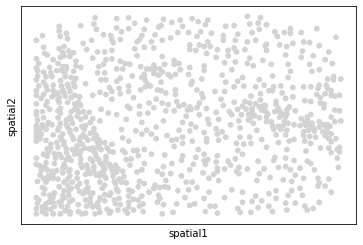

In [6]:
import scanpy as sc
sc.pl.embedding(a,basis='spatial')

# SEAM.tl.Umap

In [40]:
def Umap(a,rep='ID'):
    if rep=='ID':
        sc.pp.neighbors(a,use_rep='ID',metric='cosine',n_neighbors=15)
    else:
        sc.pp.neighbors(a,n_neighbors=15)
    sc.tl.umap(a)
    print('Sucessfully run Umap!')
    return a
        
        
    

# SEAM.tl.ID

In [17]:
import keras
from keras.models import Model
from keras.constraints import *
from keras.regularizers import *
from keras.layers import *
from keras.initializers import *
import keras.backend as K
from keras.optimizers import *



def get_distil_rep(train_x,cell_idx,num_cells,t_list,epochs=50,verbose=False,activa = 'relu',dp_rate = 0.5,low_dim = 128,l2_penalty = 0,l1_penalty = 1e-5,use_bias = False,netwidths=[512,256,128],error_threshold=2):

    SIMS_input = Input(shape=(train_x.shape[1],))
    target_input = Input(shape=(1,))
    kernel_init_func = glorot_normal()

    d1 = Dense(netwidths[0],activation=activa,kernel_initializer=kernel_init_func,kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(SIMS_input)
    # d1 = Dense(1024,activation=activa,kernel_initializer='random_uniform')(SIMS_input)
    # d1 = Dense(1024,activation=activa,kernel_initializer='random_uniform')(d1)


    d2 = Dense(netwidths[1],activation=activa,kernel_initializer=kernel_init_func,kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(d1)
    # d2 = Dense(512,activation=activa,kernel_initializer='random_uniform')(d1)
    # d2 = Dense(512,activation=activa,kernel_initializer='random_uniform')(d2)
    d2 = Dense(netwidths[2],activation='linear',kernel_initializer=kernel_init_func,use_bias=use_bias)(d2)


    # d3 = Dense(64,activation=activa,kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty))(d2)
    # d3 = Dense(256,activation=activa,kernel_initializer='random_uniform')(d2)
    # d3 = Dense(256,activation=activa,kernel_initializer='random_uniform')(d3)


    # d4 = Dense(low_dim,activation=activa,kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty))(d3)
    d4 = Dense(num_cells,activation='linear',kernel_initializer=kernel_init_func,kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(d2)
    ####################MLP################################################################################
    centerloss_embed_layer = Embedding(num_cells, low_dim)(target_input)
    centerloss_out = Lambda(lambda x: K.sum(K.square(x[0]-x[1][:,0]), 1, keepdims=True), name='center')([d2,centerloss_embed_layer])



    softmax_out = Activation('softmax',name='softmax')(d4)

    softmax_model = Model([SIMS_input,target_input],[softmax_out,centerloss_out])
    softmax_model.compile(optimizer=adam(),loss=['categorical_crossentropy',lambda y_true,y_pred:y_pred],loss_weights=[1,0])
    onehot_label = keras.utils.to_categorical(cell_idx-1,num_cells)
    # reset_weights(softmax_model)


    history=softmax_model.fit([train_x,cell_idx-1],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=epochs,shuffle=True,batch_size=64)
    while np.abs(history.history['loss'][-1]-np.max(history.history['loss']))<=error_threshold:
        print('error')
        reset_weights(softmax_model)
#         history=softmax_model.fit([train_x,cell_idx-1,dummy_input_data],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=epochs,shuffle=True,batch_size=64,verbose=verbose)
        history=softmax_model.fit([train_x,cell_idx-1],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=epochs,shuffle=True,batch_size=64)

    logit_model = Model(SIMS_input,d4)

    pred_logit = logit_model.predict(train_x)
    rep_list = []
    for t in t_list:
        cur_representation = np.exp(pred_logit/t)
        cur_representation = cur_representation/np.sum(cur_representation,axis=1,keepdims=True)
        cur_representation = np.transpose(cur_representation)
        rep_list.append(cur_representation)
    return rep_list






def ID(a,t=5,epochs=200):
    matter_list = np.array(a.var_names)
    # SIMS_id_t_list = [5,10,15,20,25,30,35,40,50]
    SIMS_id_t_list = [t]
    train_x_tmp = a.uns['train_x']
    cell_idx = a.uns['cell_idx']
    num_cells = a.shape[0]

    HEG_list = matter_list

    HEG_col_idx = [list(matter_list).index(HEG) for HEG in HEG_list]

    netwidths=[128,128,128]

    error_threshold=0
    train_x_HEG = train_x_tmp[:,HEG_col_idx]
    train_x_preprocess = train_x_HEG


    train_x_preprocess = (train_x_HEG)/np.sum(train_x_HEG,axis=1,keepdims=True)


    rep_list = get_distil_rep(train_x_preprocess,cell_idx,num_cells,SIMS_id_t_list, verbose=False,epochs=epochs,netwidths=netwidths,low_dim=netwidths[2],error_threshold=error_threshold)
    a.obsm['ID'] = rep_list[0]
    return a

Using TensorFlow backend.


In [18]:
a = ID(a,epochs=50)

/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
7145/7145 [==============================] - 1s 197us/step - loss: 6.6880 - softmax_loss: 6.6878 - center_loss: 3.9692
Epoch 2/50
7145/7145 [==============================] - 1s 118us/step - loss: 6.3716 - softmax_loss: 6.3714 - center_loss: 6.8735
Epoch 3/50
7145/7145 [==============================] - 1s 121us/step - loss: 6.1196 - softmax_loss: 6.1198 - center_loss: 13.8669
Epoch 4/50
7145/7145 [==============================] - 1s 129us/step - loss: 5.9451 - softmax_loss: 5.9458 - center_loss: 26.9874
Epoch 5/50
7145/7145 [==============================] - 1s 120us/step - loss: 5.8438 - softmax_loss: 5.8444 - center_loss: 37.9159
Epoch 6/50
7145/7145 [==============================] - 1s 126us/step - loss: 5.7830 - softmax_loss: 5.7830 - center_loss: 49.4386
Epoch 7/50
7145/7145 [==============================] - 1s 159us/step - loss: 5.7372 - softmax_loss: 5.7365 - center_loss: 60.6678
Epoch 8/50
7145/7145 [==============================] - 1s 123us/step - loss: 5.7045 

# SEAM.tl.Cluster

In [25]:
a.obsm['ID']

array([[2.0175381e-03, 2.0414342e-03, 1.4188387e-03, ..., 3.3129283e-04,
        9.2346949e-05, 3.2404915e-04],
       [3.0628054e-03, 3.1809905e-03, 1.6980509e-03, ..., 2.2013992e-04,
        4.5810531e-05, 2.2246724e-04],
       [1.5012466e-03, 1.4915384e-03, 1.6653957e-03, ..., 6.7710952e-04,
        2.6252694e-04, 6.9321657e-04],
       ...,
       [9.3352812e-04, 9.0392091e-04, 1.5985856e-03, ..., 1.2779341e-03,
        7.1910804e-04, 1.3276150e-03],
       [1.3379969e-04, 1.2110139e-04, 4.9129920e-04, ..., 2.3002492e-03,
        3.3204742e-03, 2.2339653e-03],
       [1.0890649e-04, 9.8836972e-05, 3.5967623e-04, ..., 1.6196823e-03,
        2.2732052e-03, 1.5354031e-03]], dtype=float32)

In [26]:
input_rep

array([[1.6931362e-02, 2.1084234e-02, 2.0634089e-02, ..., 1.0339787e-04,
        5.8331451e-04, 1.1634695e-04],
       [9.0408651e-04, 1.6204133e-03, 1.1061956e-03, ..., 8.2185856e-05,
        2.0326655e-04, 1.5816391e-04],
       [3.0445619e-05, 6.9218084e-05, 3.1555101e-05, ..., 1.0469264e-05,
        1.2235674e-05, 5.6130229e-05],
       ...,
       [2.9523080e-04, 8.0982703e-05, 1.6856840e-04, ..., 1.1258213e-02,
        8.8157570e-03, 7.9822587e-03],
       [6.8674528e-04, 3.8886777e-04, 5.2302767e-04, ..., 3.6891962e-03,
        3.1091715e-03, 3.8580406e-03],
       [1.4868022e-04, 4.2474952e-05, 8.3280087e-05, ..., 9.9876411e-03,
        1.1928486e-02, 1.2452365e-02]], dtype=float32)

In [29]:
import SIMLR
import scanpy as sc
import time
input_rep = a.obsm['ID']
c=6
simlr = SIMLR.SIMLR_LARGE(c, 10, 0); ###This is how we initialize an object for SIMLR. the first input is number of rank (clusters) and the second input is number of neighbors. The third one is an binary indicator whether to use memory-saving mode. you can turn it on when the number of cells are extremely large to save some memory but with the cost of efficiency.
    
S, F,val, ind = simlr.fit(input_rep)
# print('Successfully Run SIMLR! SIMLR took %f seconds in total\n' % (time.time() -         start_main))
pred_y = simlr.fast_minibatch_kmeans(F,c)

SIMLR highly recommends you to perform PCA first on the data

Please use the in-line function fast_pca on your input



/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/SIMLR/core.py:70: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  t = AnnoyIndex(d)
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/SIMLR/core.py:75: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  u = AnnoyIndex(d)


In [32]:
import SIMLR
import scanpy as sc
import time
def run_SIMLR(a,c=8,rep='ID'):
    if rep=='ID':
        input_rep = a.obsm['ID']
    elif rep=='Mean':
        input_rep = a.X
    
    start_main = time.time()
#     input_rep = SIMLR.helper.fast_pca(input_rep,100)
    print(input_rep.shape,c)
    simlr = SIMLR.SIMLR_LARGE(c, 10, 0) ###This is how we initialize an object for SIMLR. the first input is number of rank (clusters) and the second input is number of neighbors. The third one is an binary indicator whether to use memory-saving mode. you can turn it on when the number of cells are extremely large to save some memory but with the cost of efficiency.
    
    S, F,val, ind = simlr.fit(input_rep)
    print('Successfully Run SIMLR! SIMLR took %f seconds in total\n' % (time.time() -         start_main))
    pred_y = simlr.fast_minibatch_kmeans(F,c)
    print('done!')
    a.obs['SIMLR'] =pred_y.astype('int').astype('str')
    a.obs['SIMLR'] = a.obs['SIMLR'].astype('category')
    
    return a

def Cluster(a,method,cluster_param,rep='ID'):
    if method=='SIMLR':
        return run_SIMLR(a,c=cluster_param,rep=rep)
    elif method=='Louvain':
        start_main = time.time()
#         sc.pp.neighbors(a,use_rep=rep,metric='cosine',n_neighbors=15)
        sc.tl.louvain(a,resolution=cluster_param)
        print('Successfully Run Louvain! Louvain took %f seconds in total\n' % (time.time() -         start_main))
        
    elif method=='Leiden':
        start_main = time.time()
#         sc.pp.neighbors(a,use_rep=rep,metric='cosine',n_neighbors=15)
        sc.tl.leiden(a,resolution=cluster_param)
        print('Successfully Run Leiden! Leiden took %f seconds in total\n' % (time.time() -         start_main))
        
        
    return a
        








         

In [38]:
a = Umap(a)

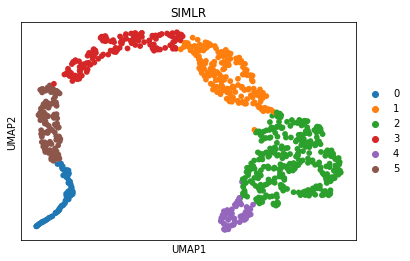

In [39]:
sc.pl.umap(a,color='SIMLR')

In [34]:
a = Cluster(a,method='SIMLR',cluster_param=6)

(902, 7145) 6
SIMLR highly recommends you to perform PCA first on the data

Please use the in-line function fast_pca on your input



/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/SIMLR/core.py:70: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  t = AnnoyIndex(d)
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/SIMLR/core.py:75: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  u = AnnoyIndex(d)


Successfully Run SIMLR! SIMLR took 2.861457 seconds in total

done!


# SEAM.tl.Diff

In [54]:
def get_m_sc(a_use,pval_thre,cls,method='pval_topk'):
#     a_use = a_m_hepa
#     pval_thre = 0.01
    sc.tl.rank_genes_groups(a_use,n_genes=a_use.shape[1],groupby=cls)
    
    rec2mat_fun = lambda rec: np.vstack([np.array(list(m)) for m in rec])
    name_mat = a_use.uns['rank_genes_groups']['names']
    pval_mat = a_use.uns['rank_genes_groups']['pvals_adj']
    score_mat = a_use.uns['rank_genes_groups']['scores']
    
    
    name_mat = rec2mat_fun(name_mat)
    pval_mat = rec2mat_fun(pval_mat)
    score_mat = rec2mat_fun(score_mat)
    n_cls = name_mat.shape[1]

    rst_list = []
    for i in range(n_cls):
        if method=='pval_thre':
            cur_idx = (pval_mat[:,i]<=pval_thre)
        elif method=='pval_topk':
            kth_p = np.sort(pval_mat[:,i])[pval_thre]
            cur_idx = (pval_mat[:,i]<=kth_p)
        elif method=='score_thre':
            cur_idx = (score_mat[:,i]>=pval_thre)
        elif method=='score_topk':
            kth_score = np.flip(np.sort(score_mat[:,i]))[pval_thre]
            cur_idx = (score_mat[:,i]>=kth_score)
            
        cur_m = name_mat[cur_idx,i]
        rst_list.append(cur_m)
        print(cur_m.shape[0])
    a_use.uns[cls+'_mz'] = rst_list
    return a_use








In [45]:
tmp = get_m_sc(a,10,cls='SIMLR',method='pval_topk')

11
13
11
11
11
11


In [114]:
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import *

def get_dist_mat_emd(a,method='emd'):

    train_x = a.uns['train_x']
    num_cells = a.shape[0]
    num_features = a.shape[1]
    cell_idx = a.uns['cell_idx']
    cell_pixel_dict = {}
    pixel_count = []
    for i in range(num_cells):
        cur_pixels = train_x[cell_idx==i+1,:]
        cell_pixel_dict[i] = cur_pixels
        pixel_count.append(cur_pixels.shape[0])

    dist_mat = np.zeros(shape=(num_features,num_cells,num_cells))
    for k in range(num_features):
        if k%10==0:
            print(k)
#         print(k)
        if method=='emd':
            for i in range(num_cells):
                for j in range(num_cells):
                    cur_dist = wasserstein_distance(cell_pixel_dict[i][:,k],cell_pixel_dict[j][:,k])
        #             cur_dist = euclidean(np.mean(cell_pixel_dict[i][:,k]),np.mean(cell_pixel_dict[j][:,k]))
        #             print(k,i,j,cur_dist)
#                     cur_dist = np.mean(cell_pixel_dict[i][:,k])-np.mean(cell_pixel_dict[j][:,k])
                    dist_mat[k,i,j] = cur_dist
        elif method=='euclidean':
            cur_dist_mat = squareform(pdist(a.X[:,k][:,None]))
            dist_mat[k,:,:] = cur_dist_mat
    a.uns['feature_wise_distmat'] = dist_mat
    return a

def get_wbr(dist_mat,pred_list):
    wbr_list = []
    for i in range(dist_mat.shape[0]):
        cur_dist_mat = dist_mat[i,:,:]
        within_sum_1 = np.sum(dist_mat[i,:,:][pred_list==1,:][:,pred_list==1])
        within_sum_0 = np.sum(dist_mat[i,:,:][pred_list==0,:][:,pred_list==0])    
        between_sum_1 = np.sum(dist_mat[i,:,:][pred_list==1,:][:,pred_list==0])
        between_sum_0 = np.sum(dist_mat[i,:,:][pred_list==0,:][:,pred_list==1])  
        wbr = (within_sum_1+within_sum_0)/(between_sum_1+between_sum_0)
        wbr_list.append(wbr)
    return np.array(wbr_list)

def get_wbr_mat(a_use,cls):
#     a_use = a
# #     wbr_thre = 10
#     cls = 'SIMLR'
#     method='topk'
    dist_mat = a_use.uns['feature_wise_distmat']
    unique_labels = np.unique(a_use.obs[cls])
    wbr_mat = np.zeros(shape=(a_use.shape[1],unique_labels.shape[0]))

    for i in range(wbr_mat.shape[1]):
        cur_label = unique_labels[i]
        cur_pred = a_use.obs[cls].copy().astype('str')
        cur_pred[cur_pred!=cur_label] = -1
        cur_pred[cur_pred==cur_label] = 0
        cur_pred = -cur_pred
        cur_wbr_list = get_wbr(dist_mat,cur_pred)
        wbr_mat[:,i] = cur_wbr_list

    a_use.uns['rank_genes_groups_emd'] = {
        'scores':wbr_mat

    }
    return a_use


def get_m_emd(a_use,thre,cls,method='topk',alg='emd'):
    a_use = get_dist_mat_emd(a_use,method=alg)
    a_use = get_wbr_mat(a_use,cls)
    
    score_mat = a_use.uns['rank_genes_groups_emd']['scores']
    n_cls = score_mat.shape[1]
    name_list = a_use.var_names
    rst_list = []
    for i in range(n_cls):
        if method=='thre':
            cur_idx = (score_mat[:,i]<=thre)
        elif method=='topk':
            kth_p = np.sort(score_mat[:,i])[thre]
            cur_idx = (score_mat[:,i]<=kth_p)
        
            
        cur_m = np.array(name_list[cur_idx])
        rst_list.append(cur_m)
        print(cur_m.shape[0])
    a_use.uns[cls+'_mz_emd'] = rst_list
    return a_use

# def Diff(a_use,cls,method='sc'):
    






In [70]:
a.uns['rank_genes_groups']

{'params': {'groupby': 'SIMLR',
  'reference': 'rest',
  'method': 't-test_overestim_var',
  'use_raw': True,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'scores': rec.array([( 1.36851597e+01,  2.67895007e+00,  16.60135   ,  9.886776  ,  18.436163  ,  13.480562  ),
            ( 1.24205999e+01,  2.64907384e+00,  15.601234  ,  9.550177  ,  17.09133   ,  12.359776  ),
            ( 1.17981224e+01,  2.61795306e+00,  15.281133  ,  9.002791  ,  14.345508  ,  11.882826  ),
            ( 1.16572266e+01,  2.39200425e+00,  15.219443  ,  8.9661875 ,  13.959264  ,  11.28029   ),
            ( 1.15116339e+01,  2.37385559e+00,  15.160839  ,  8.650172  ,  13.027767  ,  11.217467  ),
            ( 1.09996471e+01,  2.23073196e+00,  14.847307  ,  8.639172  ,  12.456964  ,  10.536551  ),
            ( 1.08729267e+01,  2.22902298e+00,  13.503208  ,  8.479856  ,  12.262003  ,  10.187115  ),
            ( 1.08425817e+01,  2.18494391e+00,  13.002346  ,  8.364593  ,  11.313946  ,   9.84898   ),

In [115]:
a_use = get_m_emd(a,20,'SIMLR',method='topk')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
21
21
21
21
21
21


In [116]:
a_use.uns['SIMLR_mz_emd']

[array(['63.25', '65.3', '66.3', '78.31', '79.27', '90.35', '92.36',
        '103.34', '106.37', '128.36', '132.43', '134.45', '144.37',
        '159.39', '165.4', '181.39', '183.41', '197.38', '199.4', '245.42',
        '261.42'], dtype=object),
 array(['52.28', '91.33', '124.41', '125.44', '135.41', '137.39', '139.42',
        '154.45', '162.41', '187.45', '195.5', '211.52', '212.52',
        '213.49', '219.5', '223.44', '231.45', '397.46', '421.42',
        '435.44', '457.45'], dtype=object),
 array(['58.29', '59.3', '63.25', '64.3', '65.3', '66.3', '71.33', '79.27',
        '90.35', '97.34', '103.34', '106.37', '117.4', '133.43', '134.45',
        '149.43', '159.39', '181.39', '197.38', '199.4', '261.42'],
       dtype=object),
 array(['104.36', '130.4', '201.44', '204.49', '206.49', '224.46',
        '229.47', '299.6', '301.44', '317.43', '341.43', '355.42',
        '363.46', '379.46', '381.46', '395.44', '397.46', '419.45',
        '441.45', '521.45', '537.43'], dtype=object),
 a

# SEAM.tl.View

In [118]:
a

AnnData object with n_obs × n_vars = 902 × 228 
    obs: 'SIMLR'
    uns: 'cell_idx', 'cell_pos', 'IMS', 'train_x', 'SIMLR_colors', 'neighbors', 'umap', 'rank_genes_groups', 'rank_genes_groups_emd', 'feature_wise_distmat', 'SIMLR_mz_emd'
    obsm: 'spatial', 'ID', 'X_umap'

In [124]:
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import *
def View(a,method='Umap'):
    
    data_all = a.uns['IMS']
    pseudo_count=1
    data_all_norm = (data_all+pseudo_count)/(np.percentile(data_all,50,axis=1,keepdims=True)+pseudo_count)
    data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
    if method=='Umap':
        fg_umap = umap.UMAP(n_components=3,n_neighbors=50).fit_transform(data_all_norm)
        a.uns['IMS_Umap'] = fg_umap
    elif method=='Tsne':
        fg_tsne = TSNE(n_components=3).fit_transform(data_all_norm)
        a.uns['IMS_Tsne'] = fg_tsne
    return a

In [125]:
a = View(a)

/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda3/envs/scaden/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda3/envs/scaden/lib/python3.7

AnnData object with n_obs × n_vars = 902 × 228 
    obs: 'SIMLR'
    uns: 'cell_idx', 'cell_pos', 'IMS', 'train_x', 'SIMLR_colors', 'neighbors', 'umap', 'rank_genes_groups', 'rank_genes_groups_emd', 'feature_wise_distmat', 'SIMLR_mz_emd', 'IMS_Umap'
    obsm: 'spatial', 'ID', 'X_umap'

/home/yzy/anaconda3/envs/scaden/lib/python3.7/site-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1225 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


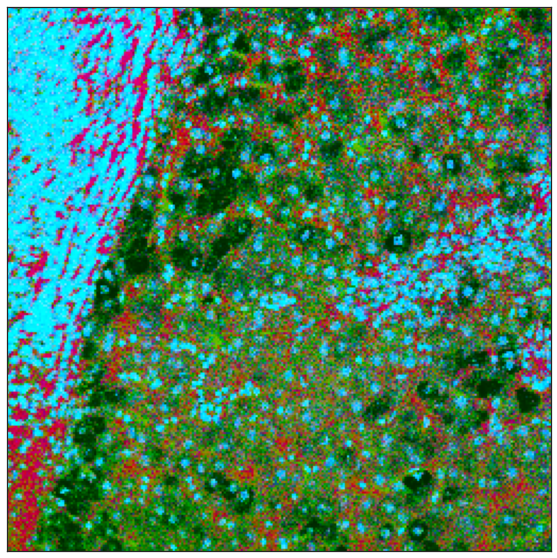

In [136]:
plot_SIMS_view(a.uns['IMS_Umap'])

# SEAM.pl.IMS

In [142]:
import matplotlib.pyplot as plt
def get_mz_img(a,mz):
    m_list = a.var_names
    img_flatten = a.uns['IMS'][:,m_list==mz]
    img_square = img_flatten.reshape(256,256)
    return img_square

def IMS(a,mz):
    mz_img = get_mz_img(a,mz)
    plt.imshow(mz_img)  
    plt.title(mz+' m/z')
    plt.show()

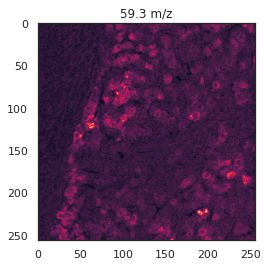

In [143]:
IMS(a,'59.3')

# SEAM.pl.Cut

In [154]:
def Cut(a,method='dot'):
    if method=='dot':
        fig,ax = plt.subplots(1,1,figsize=(4,4))
        sc.pl.embedding(a,basis='spatial',ax=ax)
    elif method=='mask':
        pred_y = np.ones(shape=(a.shape[0],))
        cmp = ['w']
        plot_label_image(a,pred_y,cmp,save=None,mask=None,figsize=(5,5),anno=False,ifshow=True)


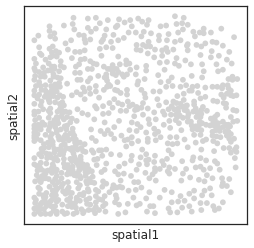

In [152]:
Cut(a,method='dot')

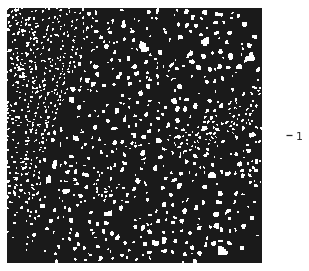

In [155]:
Cut(a,method='mask')

# SEAM.pl.ID

In [160]:
def ID(a):
    sc.pl.umap(a,color='SIMLR')

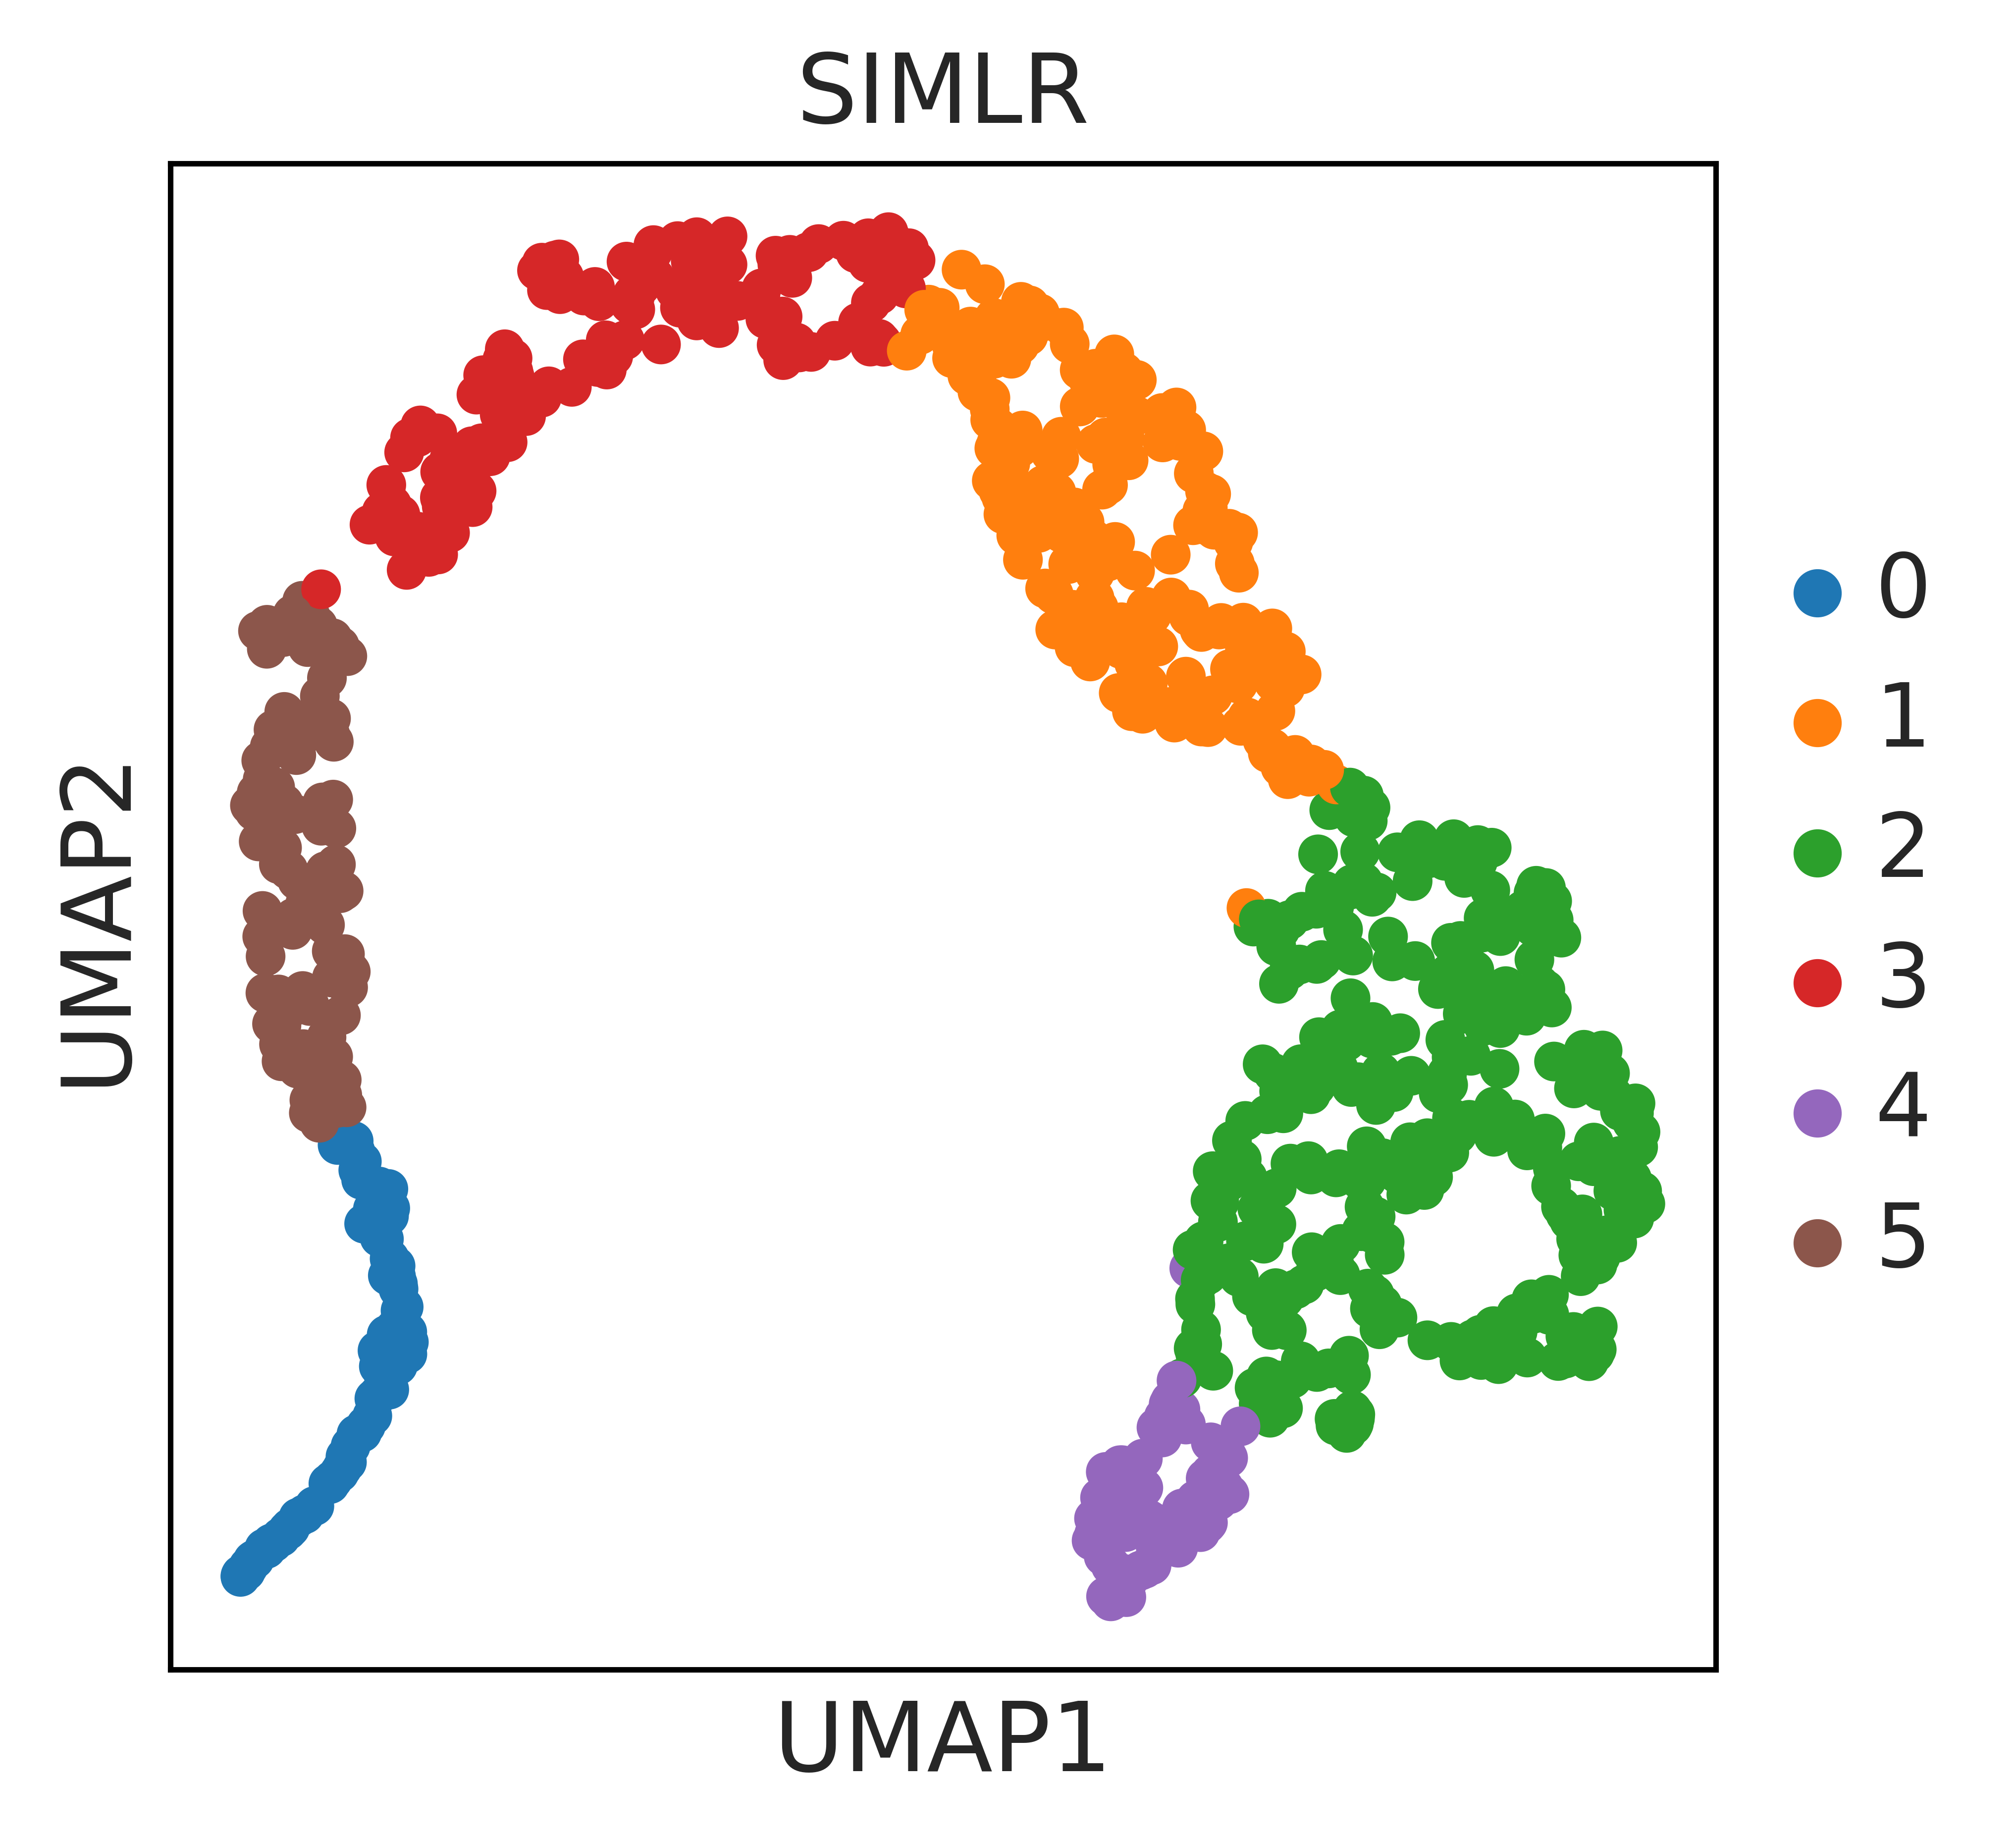

In [161]:
ID(a)

# SEAM.pl.Cluster

In [171]:
def Cluster(a,cls,groups,method='mask'):
#     groups are list of label index
    if method=='mask':
        plot_label_image(a,a.obs[cls],a.uns[cls+'_colors'],mask=groups,save=None)
    elif method=='dot':
        unique_labels = np.unique(a.obs[cls])
        sc.pl.embedding(a,basis='spatial',color=cls,groups=list(unique_labels[groups]))        
        

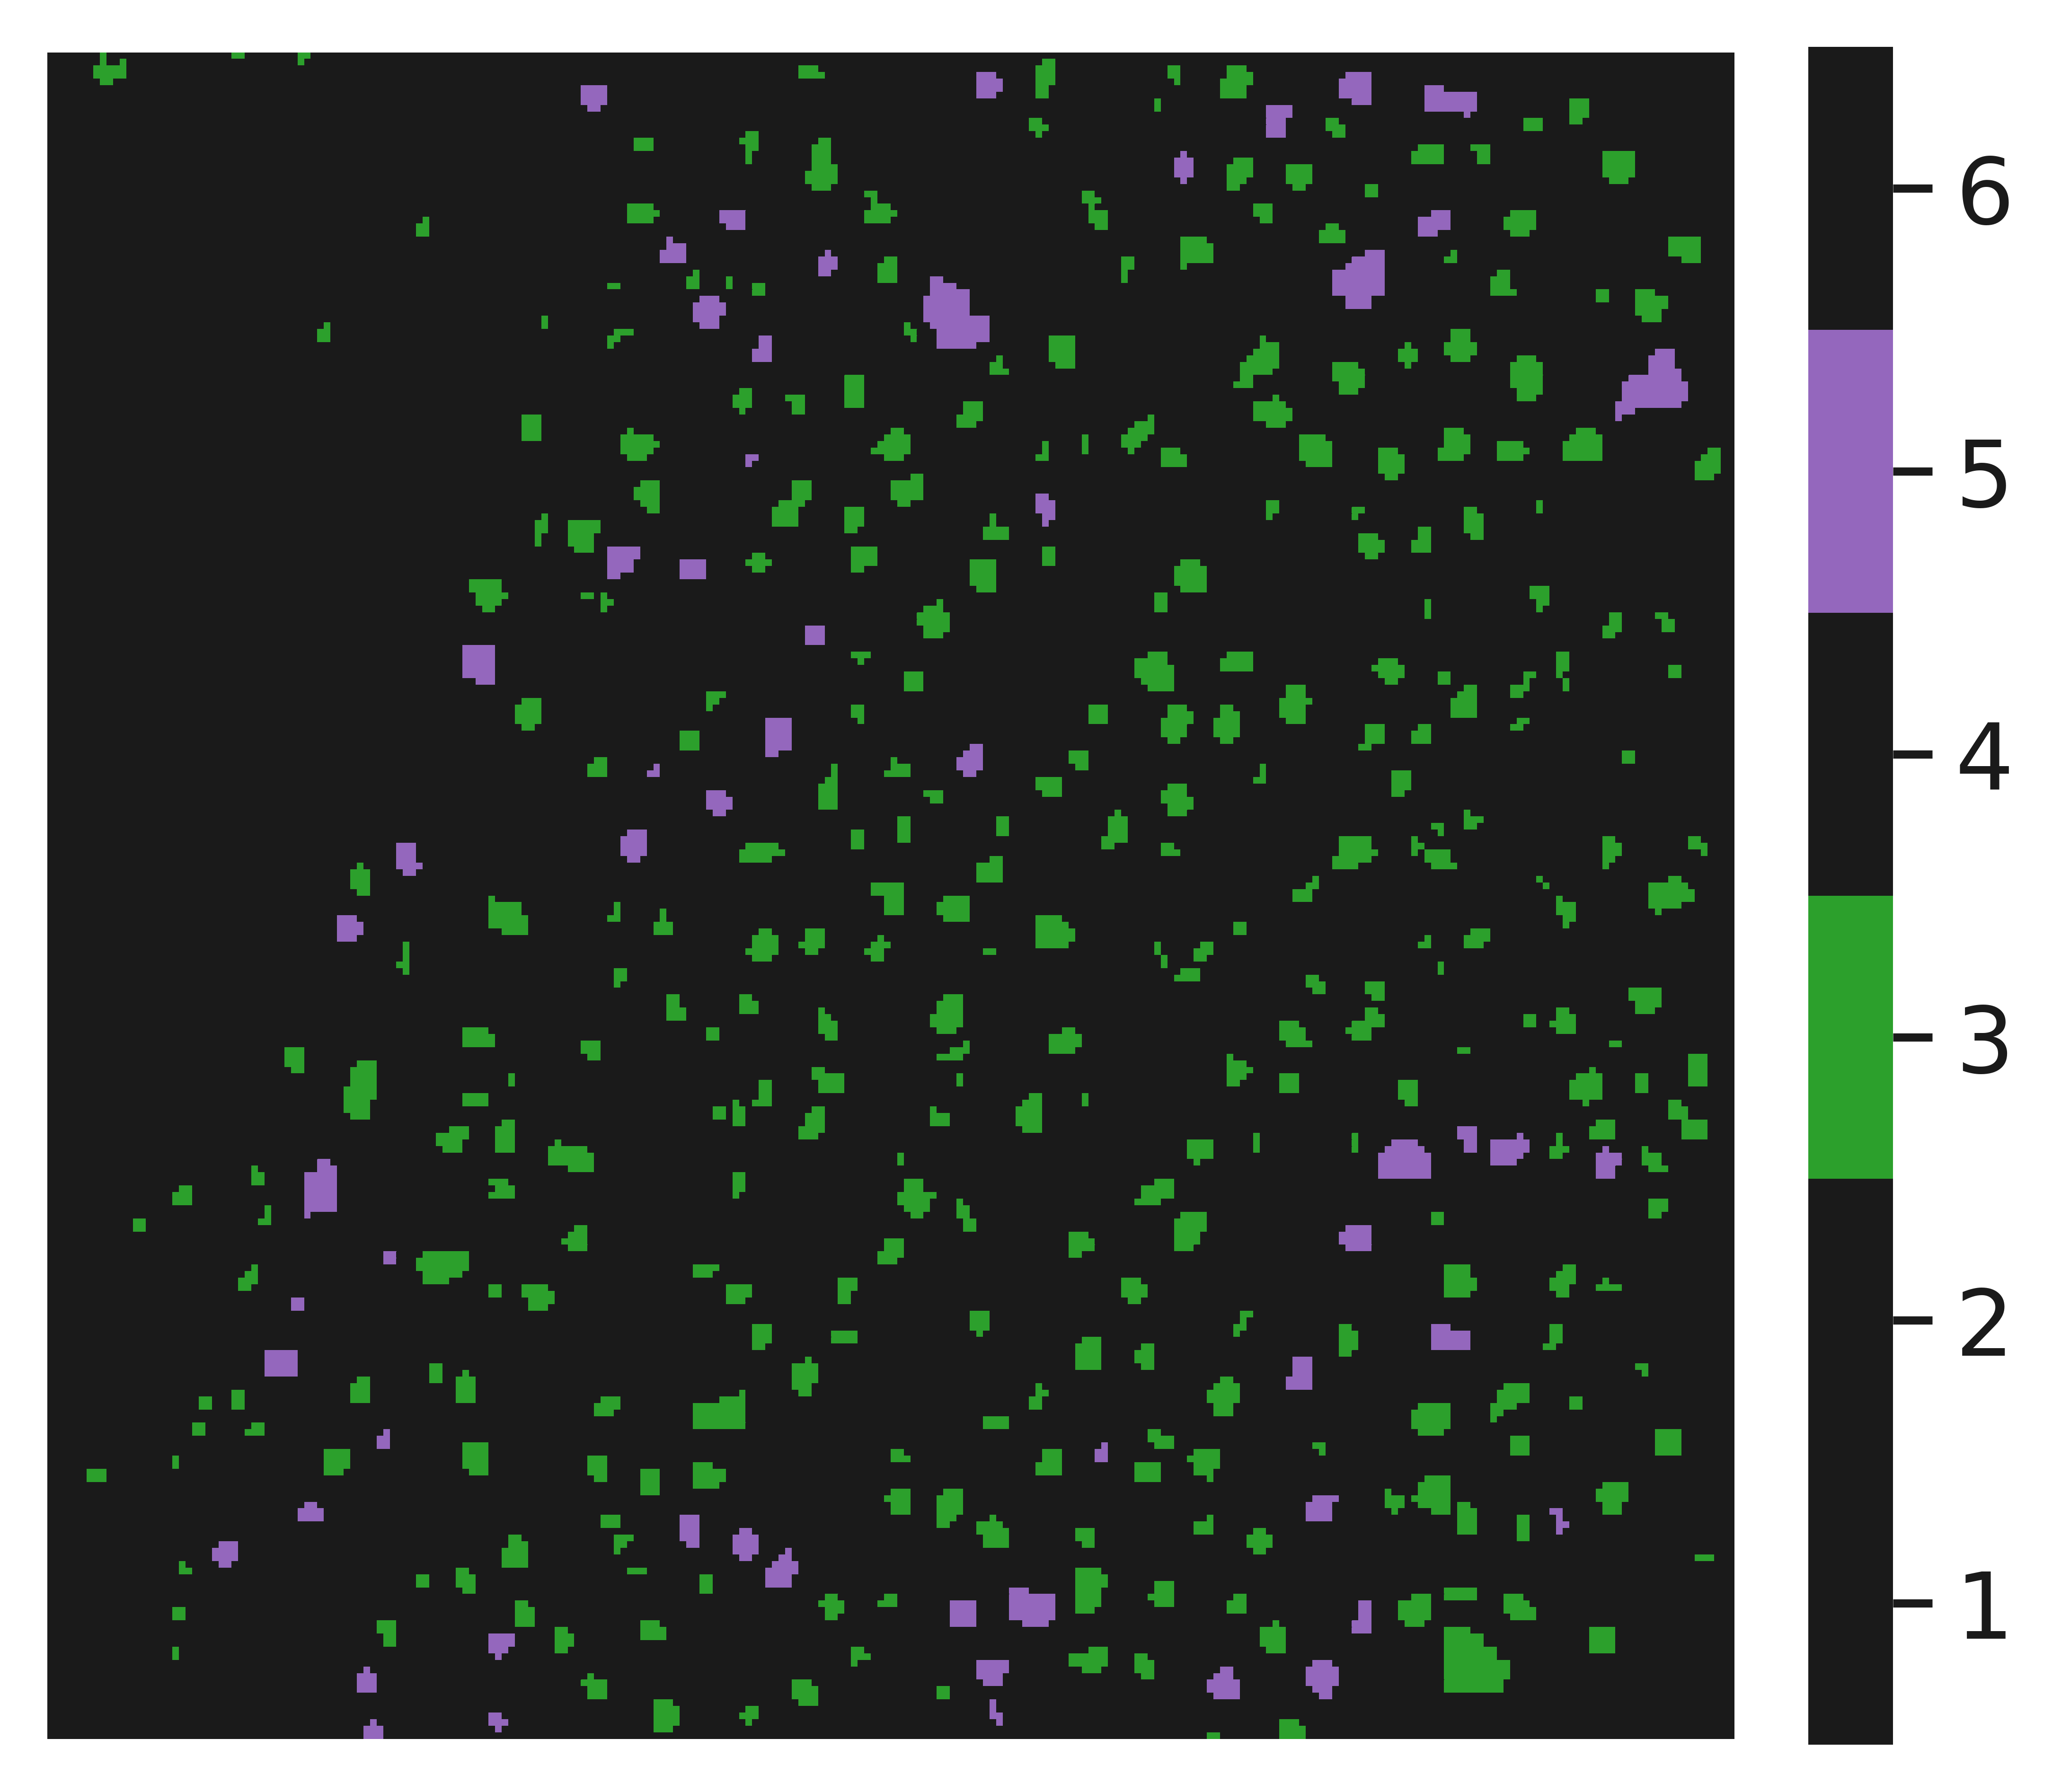

In [173]:
Cluster(a,'SIMLR',[2,4],'mask')

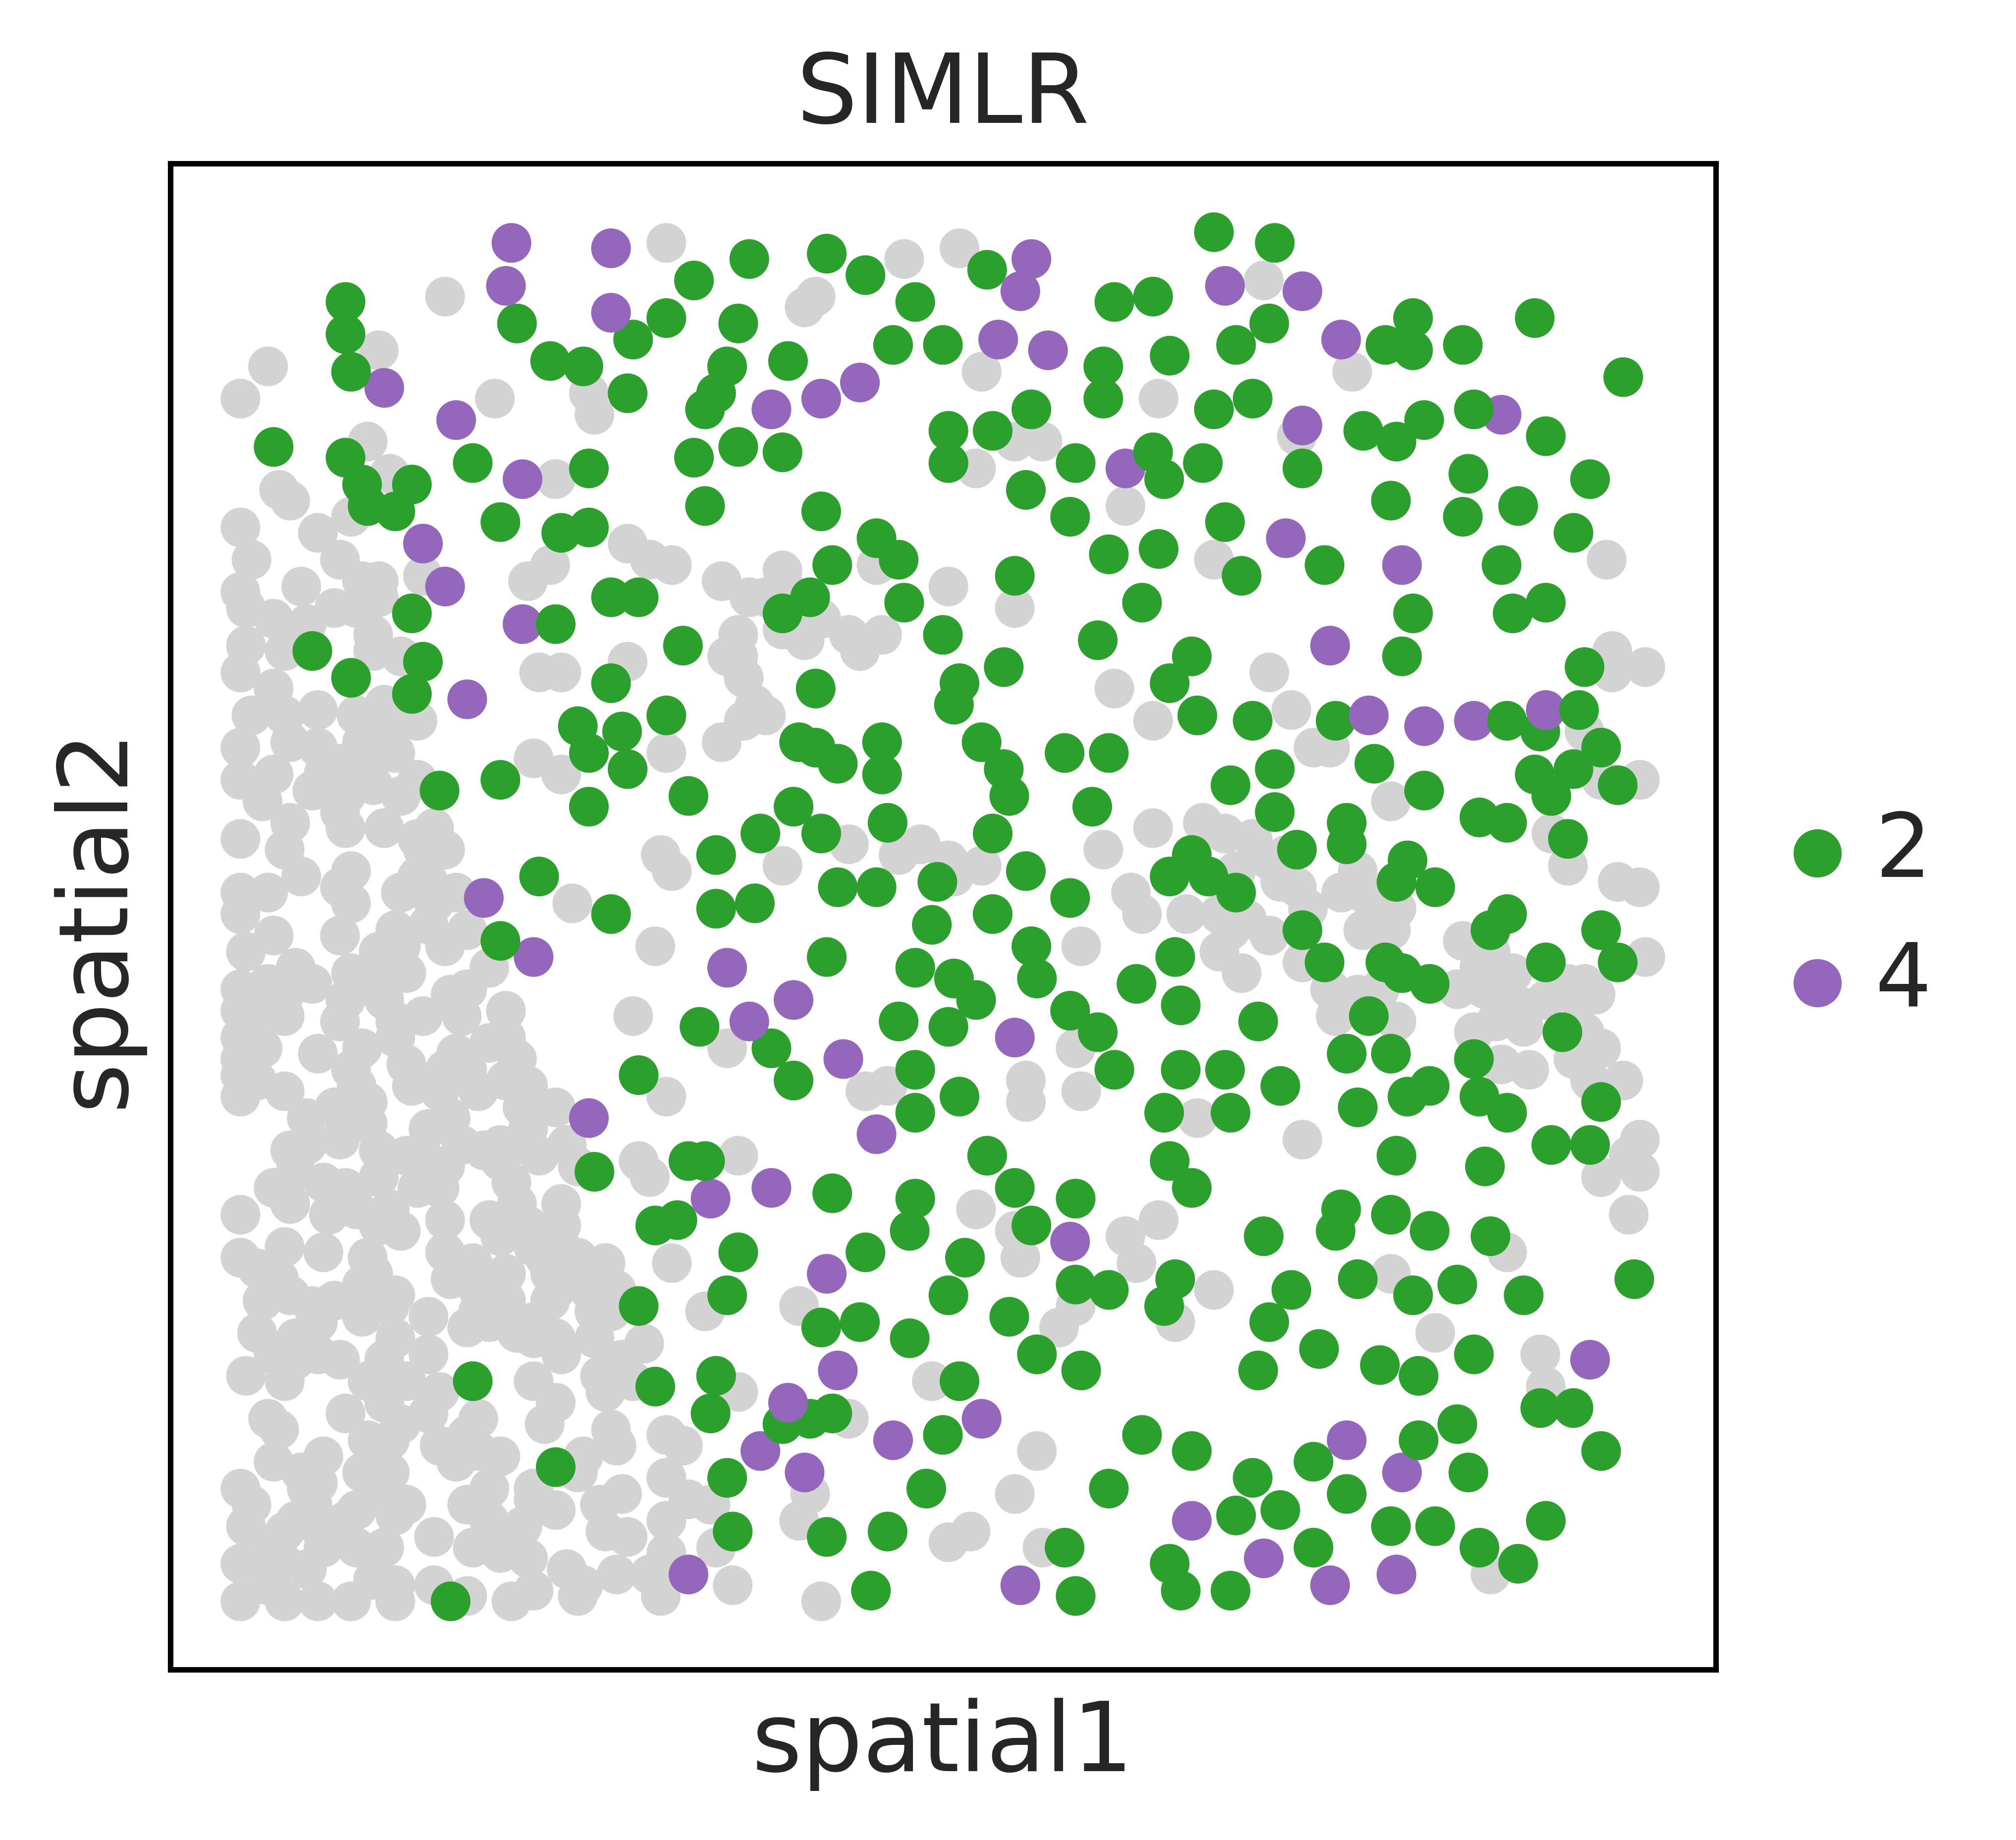

In [172]:
Cluster(a,'SIMLR',[2,4],'dot')

# SEAM.pl.Diff

In [176]:
a_use.uns['SIMLR_mz_emd']

[array(['63.25', '65.3', '66.3', '78.31', '79.27', '90.35', '92.36',
        '103.34', '106.37', '128.36', '132.43', '134.45', '144.37',
        '159.39', '165.4', '181.39', '183.41', '197.38', '199.4', '245.42',
        '261.42'], dtype=object),
 array(['52.28', '91.33', '124.41', '125.44', '135.41', '137.39', '139.42',
        '154.45', '162.41', '187.45', '195.5', '211.52', '212.52',
        '213.49', '219.5', '223.44', '231.45', '397.46', '421.42',
        '435.44', '457.45'], dtype=object),
 array(['58.29', '59.3', '63.25', '64.3', '65.3', '66.3', '71.33', '79.27',
        '90.35', '97.34', '103.34', '106.37', '117.4', '133.43', '134.45',
        '149.43', '159.39', '181.39', '197.38', '199.4', '261.42'],
       dtype=object),
 array(['104.36', '130.4', '201.44', '204.49', '206.49', '224.46',
        '229.47', '299.6', '301.44', '317.43', '341.43', '355.42',
        '363.46', '379.46', '381.46', '395.44', '397.46', '419.45',
        '441.45', '521.45', '537.43'], dtype=object),
 a

In [183]:
def Diff(a,cls,method='SIMLR_mz_emd',show_gene_labels=False):
    mzs = np.hstack(a.uns['SIMLR_mz_emd'])
    cls='SIMLR'
    sc.pl.heatmap(a,var_names=mzs,groupby=cls,standard_scale='var', 
                  cmap=heatmap_cmp,dendrogram=False,save=None,swap_axes=True,
                 show_gene_labels=show_gene_labels)


In [184]:
Diff(a_use,'SIMLR',show_gene_labels=True)

# SEAM.pl.View

In [135]:
from skimage.color import rgb2lab, lab2rgb
import seaborn as sns
import matplotlib.pyplot as plt
def plot_SIMS_view(fg_umap,save=None):
# fg_umap = a_concat[a_concat.obs['batch']=='0'].obsm['X_pca'][:,0:3]

    fg_umap_norm = MinMaxScaler().fit_transform(fg_umap)
    fg_umap_norm[:,0] = MinMaxScaler(feature_range=(0, 100)).fit_transform(fg_umap_norm[:,0][:,None])[:,0]
    fg_umap_norm[:,1] = MinMaxScaler(feature_range=(-128, 127)).fit_transform(fg_umap_norm[:,1][:,None])[:,0]
    fg_umap_norm[:,2] = MinMaxScaler(feature_range=(-128, 127)).fit_transform(fg_umap_norm[:,2][:,None])[:,0]
#     fg_umap_norm[:,2] = MinMaxScaler(feature_range=(-128, 50)).fit_transform(fg_umap_norm[:,2][:,None])[:,0]


    data_rgb = fg_umap_norm

    data_rgb_img = data_rgb.reshape(256,256,3).astype('float64')
    data_rgb_img = lab2rgb(data_rgb_img)
    sns.set(style='white')
    sns.set_color_codes('deep')
    # sns.set
    # cur_save_file = '{0}tsnemap_img_thres134_{1}_{2}.png'.format(save_path,str(bg_threshold),time_str)
    plt.figure(figsize=(10,10))
    plt.imshow(data_rgb_img)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='png',bbox_inches='tight')
        
def View(a,method='Umap'):
    plot_SIMS_view(a.uns['IMS_'+method])
    